In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import List
import tiktoken

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Tokenization

### 简介
Tokenization 的主要目的是将文本分解成更小的单位(Tokens)，减小模型输入数据的内在结构复杂度(从句子变为单词序列)，从而简化模型训练的难度。同时将字符的序列转化为Token序号的序列，便于模型输入。

Tokenization 首先确定语言的词表划分粒度，一般可分为：
* 字符级：将文本分解为字符。
* 单词级：将文本分解为单词。
* 子词级：将单词进一步分解为更小的有意义单元（如前缀、后缀）。

之后使用预定义的规则来识别 tokens, 或使用统计或机器学习技术来识别最优的 token 切分方式。例如，BPE（Byte Pair Encoding）或 SentencePiece。

最后实现一组文本序列和Tokens序列之间相互转化的函数，即可完成Tokenization部分。

### 实验要求

1. 实现字符级切分的简单tokenizer， 由 字符表， 字符到token的 encoder()函数 和 token到字符的 decoder() 函数组成。
2. 调用 现有的tokenizer实现，比如openai 的tiktoken

In [52]:
class Tokenizer:
    def __init__(
        self,
        dataPath:str
        ):
        with open(dataPath,"r",encoding="utf-8") as f:
            self.dataset = f.read()
        self.generate_vocabulary()

    def generate_vocabulary(
        self,
        ):
        # self.char2index = {
        #     'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9, 'J':10,
        #     'K':11, 'L':12, 'M':13, 'N':14, 'O':15, 'P':16, 'Q':17, 'R':18, 'S':19,
        #     'T':20, 'U':21, 'V':22, 'W':23, 'X':24, 'Y':25, 'Z':26, 'a':27, 'b':28,
        #     'c':29, 'd':30, 'e':31, 'f':32, 'g':33, 'h':34, 'i':35, 'j':36, 'k':37,
        #     'l':38, 'm':39, 'n':40, 'o':41, 'p':42, 'q':43, 'r':44, 's':45, 't':46,
        #     'u':47, 'v':48, 'w':49, 'x':50, 'y':51, 'z':52, ' ':53, ',':54, '.':55,
        #     '!':56, '?':57, ':':58, ';':59, "'":60, '"':61, '0':62, '1':63, '2':64,
        #     }
        # self.index2char = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z', 27: ' ', 28: 'a', 29: 'b', 30: 'c', 31: 'd', 32: 'e', 33: 'f', 34: 'g', 35: 'h', 36: 'i', 37: 'j', 38: 'k', 39: 'l', 40: 'm', 41: 'n', 42: 'o', 43: 'p', 44: 'q', 45: 'r', 46: 's', 47: 't', 48: 'u', 49: 'v', 50: 'w', 51: 'x', 52: 'y', 53: 'z'}
        """
        TODO:
        """

        

    def encode(
        self,
        sentence : str,
        ) -> torch.Tensor:
        """
        TODO:
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input  : "ABCD"
        output : Tensor([0,1,2,3]) 
        注意: 为了后续实验方便，输出Tensor的数据类型dtype 为torch.long。
        """
        # for char in sentence:
        #     if char not in self.char2index:
        #         raise ValueError("Invalid character in sentence")
        ans = torch.tensor([ord(char) for char in sentence],dtype=torch.long)
        ans = torch.cat([torch.tensor([0],dtype=torch.long),ans])
        return ans
    
    def decode(
        self,
        tokens : torch.Tensor,
        ) -> str:
        """
        TODO:
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input : Tensor([0,1,2,3]) 
        output : "ABCD"
        """
        ans = ""
        for token in tokens:
            if token == 0:
                continue
            ans += chr(token)
        return ans

# enc = tiktoken.get_encoding("o200k_base")
# print(enc)

### 定义 dataloader 和 dataset

为了高效加载数据，我们需要把输入文件接入 PyTorch 的数据加载器中。在这里我们定义 `ShakespeareDataset` 类用于加载数据集，用 PyTorch 的 `DataLoader` 类来实现数据加载。


In [53]:
class ShakespeareDataset(Dataset):
    def __init__(self, filepath, tokenizer, chunk_size):
        self.tokenizer = tokenizer
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
        self.encoded = self.tokenizer.encode(text)
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.encoded) - self.chunk_size

    def __getitem__(self, idx):
        #TODO: 提取一段文本(长度为 chunk_size）作为输入，以及这段文本的每一个字符的下一个字符作为标签
        # example(not correspond to real text): chunk = tensor([ 0, 20, 49, 58, 59])
        #         label = tensor([20, 49, 58, 59, 19])
        # decoded chunk: "The "
        # decoded label: "he T"
        chunk = self.encoded[idx:idx+self.chunk_size]
        label = self.encoded[idx+1:idx+self.chunk_size+1]
        return chunk, label

tokenizer = Tokenizer(dataPath="input.txt")

def create_dataloader(filepath, tokenizer, chunk_size, batch_size, shuffle=True):
    dataset = ShakespeareDataset(filepath, tokenizer, chunk_size)
    train_dataset,val_dataset = torch.utils.data.random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, val_dataloader


train_dataloader,val_dataloader = create_dataloader('input.txt', tokenizer, chunk_size=200, batch_size=2)


注意力的计算公式为：
$$
Head = Attention(x)=Softmax(M\cdot QK^T)V\\
Q=xW_{q},K=xW_{k}, V=xW_{v}
$$
这里实现的一些数学技巧可以参见attention.ipynb

In [54]:
class HeadAttention(nn.Module):
    def __init__(self, seq_len:int, embed_size:int, hidden_size:int):
        super().__init__()
        # embed_size: dimension for input embedding vector
        # hidden_size: dimension for hidden vector. eg. x:(..., embed_size) --to_q--> query_vector:(..., hidden_size)

        # a triangular bool matrix for mask
        self.register_buffer("tril", torch.tril(torch.ones(seq_len, seq_len)))
        
        # TODO: init three matrix, to_q, to_k, to_v.
        self.to_q = nn.Linear(embed_size, hidden_size, bias=False) # hidden_size ?
        self.to_k = nn.Linear(embed_size, hidden_size, bias=False)
        self.to_v = nn.Linear(embed_size, hidden_size, bias=False)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        # return (batch_size, seq_len, hidden_size)
        # TODO: implement the attention mechanism
        B, T, C = inputs.shape
        # 1. get q, k, v
        q = self.to_q(inputs) # (batch_size, seq_len, hidden_size)
        k = self.to_k(inputs)
        v = self.to_v(inputs)
        # 2. calculate attention score
        Score = q @ k.transpose(-1,-2)
        Score = Score / (C ** 0.5)
        # 3. calculate attention score with mask
        Score = Score.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        # 4. calculate softmax
        Score = F.softmax(Score, dim=-1)
        # 5. calculate output
        output = Score @ v
        return output

Transformer中使用的注意力机制时会使用多个注意力头，期望每个注意力头能够注意到不同的信息。
所以实际公式需要修改如下
$$
MultiHeadAttention(x)=[Head_0, Head_1,...,Head_h]W_o\\
Head_i = Attention(x)=Softmax(M\cdot Q_iK_i^T)V_i\\
Q_i=xW_{iq},K=xW_{ik}, V=xW_{iv}
$$
在搭建网络的过程中，同学们可能会用到nn.ModuleList这个库，每个$Head_i$的计算可以直接使用上面已经实现的单头注意力计算。
最后对于这些注意力头再使用一个简单的线性层/矩阵$W_o$汇总信息即可

In [55]:
class MultiHeadAttention(nn.Module):
    # MultiHeadAttention is consist of many HeadAttention output.
    # concat all this head attention output o_i, then merge them with a projection matrix W_o, as [o_1, o_2, ...] x W_o
    # The reason for using multi-head attention is that we want each head to be able to extract different features
    def __init__(self, n_heads:int, head_size:int, seq_len:int, embed_size:int):
        # n_heads is the number of head attention
        # head_size is the hidden_size in each HeadAttention
        super().__init__()
        head_size = embed_size // n_heads
        #TODO: implement heads and projection
        self.heads = nn.ModuleList([HeadAttention(seq_len, embed_size, head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size), make sure embed_size=n_heads x head_size
        # return: (batch_size, seq_len, embed_size)
        # TODO:
        outputs = [head(inputs) for head in self.heads]
        outputs = torch.cat(outputs, dim=-1)
        outputs = self.projection(outputs)
        return outputs

## 专家网络 Expert

Expert即为标准Transformer中的FeedForward模块。

在经过MultiHeadAttention 模块后，seq_len中的每一个Embedding都对应了前文信息的加权求和。在经过FeedForward模块时，模型对每一个位置的Embedding进行了两次线性变换和一次非线性变换，可以视为对当前语境下的信息进行加工。知识编辑的一些研究表明，FeedForword 模块参数包含了大量的事实性知识。

一个直观的想法是，类比于MultiHeadAttention，我们在每一层训练多个FeedForward模块，对于不同位置的Embedding使用不同的FeedForward模块处理对应的信息。就好像每层有多个Expert,每个Expert都负责处理一类数据的深加工，因此我们称FeedForward为Expert。

实现方面:

FeedForward层由两层简单的线性层组成，对于一个(batch_size, seq_len, embed_size)输入的向量x
只在最后一个维度上进行计算，以实现词的特征维度上的交互(注意力机制是词之间的交互)。
其首先用一个线性层将x最后一维扩大至原先4倍，然后继续用一个线性层还原回原先的维度。

In [56]:
class Expert(nn.Module):
    def __init__(self, embed_size:int):
        super().__init__()
        #TODO: init two linear layer
        self.linear1 = nn.Linear(embed_size, 4*embed_size)
        self.relu = nn.ReLU() # ?
        self.linear2 = nn.Linear(4*embed_size, embed_size)

    def forward(self, inputs):
        # inputs: (batch_size, seq_len, embed_size)
        # -> mid: (batch_size, seq_len, 4 x embed_size)
        # -> outputs: (batch_size, seq_len, embed_size)
        return self.linear2(self.relu(self.linear1(inputs)))

## 选通网络 TopkRouter

在实现了单个Expert后，我们要设计一个选通网络决策每个Embedding要使用那个Expert计算


### 为了说明选通网络的实现方式，我们定义一下记号：

inputs.shape = [batch_size, seq_len, embed_size] = [1, 8, 16] 

即输入有batch_size=1个数据点，该数据有seq_len长度的context，即包含seq_len=8个Embedding，每个Embedding长度为embed_dim=16。

记 num_expert = 4, 即该层包含 num_expert 个并列的Expert。

记 active_expert = 2, 即计算每个Embedding仅有 active_expert 个Expert 参与计算。

### 选通网络计算
对于有seq_len=8的数据，如果每个Expert都参与计算每一个Embedding，那么一共需要计算 seq_len*embed_size = 32 次， 这极大的增加了模型计算量，因此我们往往只激活其中的active_experts个Expert，这要求我们对每一个Embedding计算最合适的active_experts个 Expert。

对于单个Expert 的原版Transformer来说：

$$
outputs[0,seq] = FeedForward(inputs[0,seq])
$$

对于多个Expert的网络：

$$
outputs[0,seq] = \sum_{i \in range(num\_model)} \alpha_{i} Expert_{i}(inputs[0,seq])
$$

$$
\alpha_{i} = \left\{
\begin{array}{ll}
    1 & Expert_{i}  \text{is selected} \\
    0 & Expert_{i}  \text{is not selected} \\
\end{array}
\right.
$$
将$\{\alpha_0,\alpha_1,\dots,\alpha_{num_experts-1}\}$记为向量$\alpha$:
$$
outputs[0,seq] = \alpha \cdot \{Expert_i(inputs[0,seq])\}
$$

一个选通0,2号Expert的$\alpha$的例子是$[1,0,1,0]$

问题在于如何求得 $\alpha$, 对于一个Embedding ，我们使用神经网络对每个Expert打分，在根据分数计算$\alpha$

$$
score[0,seq] = MLP(inputs[0,seq])  \\
\alpha = topK(score[0,seq])
$$

例如：

$$
score[0,seq] = [11.32,1.54,14.83,-1.90] \\
\alpha = [1,0,1,0]
$$

从优化的角度来说，$\alpha$取前k大的分数的下标（即argmax），这个操作是不可导的，这里我们用之前在"attention.ipynb"中提到的技巧处理这里的计算。

$$
mask(score[0,seq]) = [11.32,-inf,14.83,-inf] \\
\alpha = softmax(mask(score[0,seq])) = [0.028,0,0.971,0] \\
index = [1,0,1,0]
$$

我们用这个$\alpha$和$index$用做选通网络.

In [57]:
# First define the top k router module
class TopkRouter(nn.Module):
    def __init__(self, embed_size, num_experts, active_experts):
        ## TODO
        super().__init__()
        ## embed_size : dimension of embedding 
        ## num_experts : how many Experts per layer
        ## active_experts: only active_experts out of num_experts are selected to process Embeddings per token.
        self.k = active_experts
        self.linear = nn.Linear(embed_size, num_experts)

    def forward(self, inputs):
        ## TODO
        ## 完成这部分时，注意使用Softmax()对router_output做标准化。同时注意这部分所用操作的可导性。
        ## 输入值
        ## inputs is the output tensor from multihead self attention block, shape (B:batch size, T: seq_len, C: embed_size)
        ## 返回值
        ## router_output: normalized weight of Experts, 即教程中的 \alpha
        ## indices:   index of selected Experts, 即教程中的 index
        linear_output = self.linear(inputs)
        topk, indices = torch.topk(linear_output, self.k, dim=-1)
        inf = torch.full_like(linear_output, -float('inf'))
        masked = inf.scatter(-1, indices, topk)
        router_output = F.softmax(masked, dim=-1)
        return router_output, indices

## 稀疏专家网络 SparseMoE

![moe](./moeSparse.png)

在定义完Expert 和 TopkRouter后，我们可以定义SparseMoE模块。

在前向过程中，对于inputs.shape = [Batch_size,seq_len,embed_size]第二维度seq_len个Embedding,我们先利用TopkRouter计算出选通专家序号indices以及专家权重router_output。

我们将Embedding通过选通的Expert得出active_expert个新的Embedding，然后使用router_output的作为权重对新的Embedding加权求和作为输出。


In [58]:
class SparseMoE(nn.Module):
    def __init__(self, embed_size:int, num_experts:int, active_experts:int):
        ## TODO
        super().__init__()
        self.num_experts = num_experts
        self.k = active_experts
        self.experts = nn.ModuleList([Expert(embed_size) for _ in range(num_experts)])
        self.router = TopkRouter(embed_size, num_experts, active_experts)

    def forward(self, x):
        ## TODO
        # input: (batch_size, seq_len, embed_size)
        # weight, indices = self.router(inputs) #indices: [2,5,7...]
        # outputs = torch.zeros_like(inputs)

        # flat_inputs = inputs.view(-1, inputs.size(-1))
        # flat_weight = weight.view(-1, weight.size(-1))

        # for i in range(len(self.experts)):
        #     mask = (indices == i)
        #     flag = mask.any()
        #     if flag:
        #         expert_out = self.experts[i](flat_inputs[flag]) #?
        #         we = flat_weight[flag][i].unsqueeze(1)
        #         expert_out = expert_out * we
        #         outputs[flag] += expert_out.squeeze(1)

        gating_output, indices = self.router(x)
        final_output = torch.zeros_like(x)

        # Reshape inputs for batch processing
        flat_x = x.view(-1, x.size(-1))
        flat_gating_output = gating_output.view(-1, gating_output.size(-1))

        # Process each expert in parallel
        for i, expert in enumerate(self.experts):
            # Create a mask for the inputs where the current expert is in top-k
            expert_mask = (indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)

            if flat_mask.any():
                expert_input = flat_x[flat_mask]
                expert_output = expert(expert_input)

                # Extract and apply gating scores
                gating_scores = flat_gating_output[flat_mask, i].unsqueeze(1)
                weighted_output = expert_output * gating_scores

                # Update final output additively by indexing and adding
                final_output[expert_mask] += weighted_output.squeeze(1)

        return final_output


Transformer由一层层的block堆叠而成，其中每个block的结构从模型的结构图展开中可以看到，由LayerNorm，Masked multi head attention，(SparseMoE)FeedForward组成。

对于一个表示句子的输入向量x，其首先会经过Layer Normalization层.
Layer Normalization 层对于一个 句子个数x句子长度x单词向量维度 的输入 x, 会在最后两维上进行规范化处理，起到稳定训练的作用。

$$
LN(x)=\frac{x-mean(x)}{\sqrt{var(x)+\epsilon}}\cdot\gamma+\beta
$$

其中mean和var都是在最后两个维度上进行的，layernorm的实现同学们可以直接调用nn.LayerNorm
经过layernorm层后，再经过Mask multi head attention层之后，会在+号处再次和原始的输入进行相加，这样的做法能够提高训练的稳定性。有兴趣的同学可以从梯度角度思考原因，或者搜索残差连接相关资料进行学习。
之后再同样经过一层layernorm和feedforwad之后，就可以得到block块的输出了。
即 x' = x+MHA(LN(x)), y = FFN(LN(x'))+x'

In [59]:
class Block(nn.Module):
    # Transformer basic block, consist of MultiHeadAttention, FeedForward and layer normalization
    def __init__(self, embed_size:int, n_heads:int, seq_len:int, num_experts:int, active_experts:int):
        super().__init__()
        # TODO: implement block structure
        self.mha = MultiHeadAttention(n_heads, embed_size//n_heads, seq_len, embed_size)
        self.smoe = SparseMoE(embed_size, num_experts, active_experts)
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        #TODO: forward with residual connection
        x = inputs + self.mha(self.ln1(inputs))
        x = x + self.smoe(self.ln2(x))
        return x

In [60]:
class SparseMoETransformer(nn.Module):
    # Transformer decoder, consist of 
    # token embedding layer and position_embedding(position_embedding 可以理解为对位置编码，感兴趣的同学可以查阅原文，这里可以看为vocab_len = seq_len的Embedding)
    # a stack of Transformer basic block
    # a layernorm and output linear layer
    def __init__(self, vocab_size:int, seq_len:int, embed_size:int, n_layers:int, n_heads:int, num_experts:int, active_experts:int):
        # vocab_size is the number of word in vocabulary dict
        # seq_len is the sequence length/sentence length
        # embed_size is the embedding vector dimension
        super().__init__()
        # TODO: 
        self.seq_len = seq_len
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(seq_len, embed_size)
        self.blocks = nn.Sequential(*[Block(embed_size, n_heads, seq_len, num_experts, active_experts) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)

    def forward(self, inputs, labels=None):
        # labels: the (ground) true output 
        # TODO: implement the forward function of the transformer

        # inputs:(batch_size, seq_len, )
        batch_size, seq_len, = inputs.shape
        # embedding:(batch_size, seq_len, embed_size)
        embedding = self.token_embedding(inputs)
        embedding += self.position_embedding(torch.arange(seq_len, device=device))
        # attens:(batch_size, seq_len, embed_size)
        attens = self.norm(self.blocks(embedding))
        # logits:(batch_size, seq_len, vocab_size)
        logits = self.linear(attens)

        # compute the loss
        
        if labels is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.shape
            logits = logits.view(batch_size * seq_len, vocab_size)
            labels = labels.view(batch_size * seq_len)
            loss = F.cross_entropy(logits, labels)
        return logits, loss
    
    def generate(self, inputs, max_new_tokens):
        inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)
        device = next(self.parameters()).device  
        inputs = inputs.to(device)
        if inputs.size(1) > self.seq_len:
            inputs = inputs[:, :self.seq_len]
        generated = inputs
        for _ in range(max_new_tokens):
            if generated.size(1) > self.seq_len:
                generated_input = generated[:, -self.seq_len:]
            else:
                generated_input = generated
            logits, _ = self.forward(generated_input)
            last_logits = logits[:, -1, :]  
            next_token_ids = torch.argmax(last_logits, dim=-1)  
            next_token_ids = next_token_ids.unsqueeze(-1)  
            generated = torch.cat([generated, next_token_ids], dim=1)  
        return generated
    

# 训练循环

如果你已经完成了模型定义等内容，训练的过程实际上在高度封装的 Pytorch 库中非常简单, 因为你并不需要写对应的反向传播。



#### Loss 

Loss 用来**衡量**模型预测与真实值之间的**差距**。

常见的几个 Loss 函数：

* 交叉熵：$\text{CrossEntropy Loss} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$
* 均方误差：$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$
* 绝对误差：$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y_i}|$

不同的 loss 对应不同的优化目标，如果写错 loss 函数会导致模型不收敛/性能很差。

#### 训练循环

当我们写好 Optimizer 和 Loss 之后，对应的训练循环就十分简单了。

我们只需要做以下事情：

* 从 dataloader 里面拿到一个 batch 的数据以及标签
* 将数据送入模型，进行前向传播
* 拿到模型输出的 logits
* 将 logits 和 标签进行 loss 计算
* 用 Optimizer 
    * 清空梯度
    * 反向传播
    * 更新参数

In [61]:
def train(model, dataloader, epoch, device):
    # Optimizer 会根据模型的输出和真实标签计算梯度，然后利用反向传播算法更新模型的参数。
    # 在本实验中你可以将 Optimizer 视作黑盒，只需要知道如何使用即可。
    # 找一个合适的 Optimizer。对不同的任务，模型，最适合的优化器是不一样的，你可以先尝试最常用的 Adam，如果有兴趣可以看看其他的优化器。
    # docs see: https://pytorch.org/docs/stable/optim.html 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    total_loss = 0
    from tqdm import tqdm
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # TODO: implement the training process, and compute the training loss and validation loss
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        logits, loss = model(inputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch} Loss: {total_loss / len(dataloader)}')

    return total_loss / len(dataloader)

def validate(model, dataloader, epoch, device):
    model.eval()
    # TODO: 实现验证函数。与训练函数类似，但不需要计算梯度。
    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits, loss = model(inputs, targets)
        total_loss += loss.item()
    print(f'Epoch {epoch} Validation Loss: {total_loss / len(dataloader)}')
    return total_loss / len(dataloader)

  0%|          | 0/1743 [00:00<?, ?it/s]

100%|██████████| 1743/1743 [02:22<00:00, 12.22it/s]


Epoch 0 Loss: 1.7497408216326522
Epoch 0 Validation Loss: 1.392071222493408
Epoch 0 Train Loss: 1.7497408216326522, Valid Loss: 1.392071222493408


100%|██████████| 1743/1743 [02:21<00:00, 12.29it/s]


Epoch 1 Loss: 1.3363439250252265
Epoch 1 Validation Loss: 1.2971134664268669
Epoch 1 Train Loss: 1.3363439250252265, Valid Loss: 1.2971134664268669


100%|██████████| 1743/1743 [02:22<00:00, 12.24it/s]


Epoch 2 Loss: 1.2695942013276014
Epoch 2 Validation Loss: 1.250436696164105
Epoch 2 Train Loss: 1.2695942013276014, Valid Loss: 1.250436696164105


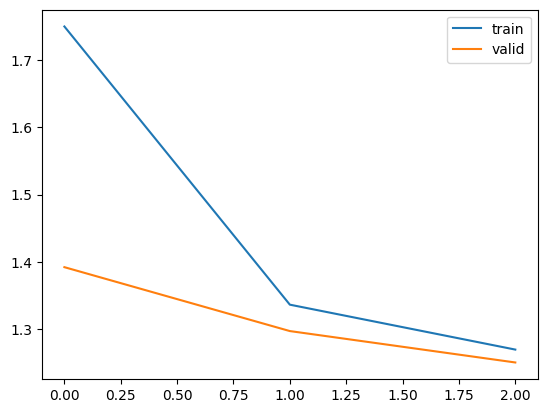

/tmp/ipykernel_309931/1611702591.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)


I could pick my lance is not to the sea
Of some of the sea to be a sentence of the sea
And see the sea to make a sentence


<Figure size 640x480 with 0 Axes>

In [62]:
dataloader = create_dataloader('input.txt', tokenizer, chunk_size=50, batch_size=512)
model = SparseMoETransformer(vocab_size=128, seq_len=50, embed_size=64, n_layers=3, n_heads=8, num_experts=8, active_experts=2).to(device)
import matplotlib.pyplot as plt

# 训练模型
train_list = []
valid_list = []
def run(model, train_dataloader, valid_dataloader, device, epochs=10):
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, epoch, device)
        valid_loss = validate(model, valid_dataloader, epoch, device)
        print(f'Epoch {epoch} Train Loss: {train_loss}, Valid Loss: {valid_loss}')
        train_list.append(train_loss)
        valid_list.append(valid_loss)
    plt.plot(train_list, label='train')
    plt.plot(valid_list, label='valid')
    plt.legend()
    plt.show()
    plt.savefig('loss.png')

#TODO: 用 matplotlib plot 训练过程中的 loss 变化


# run(model, dataloader[0], None, device, epochs=100)
run(model, dataloader[0], dataloader[1], device, epochs=10)

# 保存模型
torch.save(model.state_dict(), 'model.pth')

model.load_state_dict(torch.load('model.pth'))

print(tokenizer.decode(model.generate("I could pick my lance",max_new_tokens=100)[0].tolist()))

In [63]:
model.load_state_dict(torch.load('model.pth'))

print(tokenizer.decode(model.generate("I could pick my lance",max_new_tokens=100)[0].tolist()))

/tmp/ipykernel_309931/1611702591.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)


I could pick my lance is not to the sea
Of some of the sea to be a sentence of the sea
And see the sea to make a sentence
